# 6. 2値分類
- アイリスデータセットで単層線形回帰をやってみる(ロジスティック回帰モデル)
- 過学習についてもここでやる

In [25]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch import nn
from torch import optim
from torchinfo import summary
from torchviz import make_dot
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm import tqdm

plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['axes.grid'] = True

In [9]:
#
# アイリスデータセットの読み込み
#

iris = load_iris()
x_org, y_org = iris.data, iris.target
print(x_org.shape)
print(y_org.shape)

(150, 4)
(150,)


In [10]:
# 本来3値だけど，今回は2つしか使わない
x_data = iris.data[:100, :2]
y_data = iris.target[:100]

print(x_data.shape)
print(y_data.shape)

(100, 2)
(100,)


In [12]:
#
# データを学習 / 検証で分解
#

x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data,
    train_size=70, test_size=30,
    random_state=123)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(70, 2)
(70,)
(30, 2)
(30,)


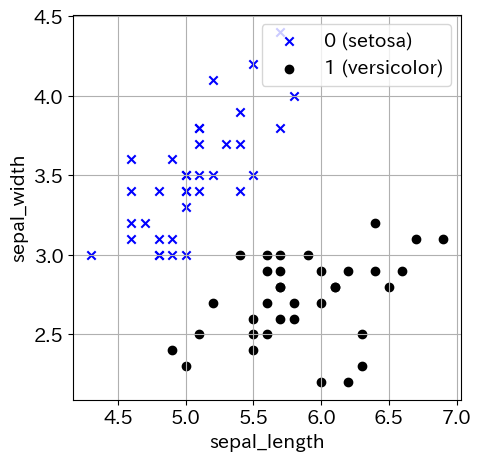

In [13]:
#
# データ可視化
#

x_t0 = x_train[y_train==0]
x_t1 = x_train[y_train==1]
plt.scatter(x_t0[:, 0], x_t0[:, 1], marker='x', c='b', label='0 (setosa)')
plt.scatter(x_t1[:, 0], x_t1[:, 1], marker='o', c='k', label='1 (versicolor)')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.legend()
plt.show()

In [14]:
#
# モデル定義
#

n_input = x_train.shape[1]
n_output = 1

In [21]:
class Net(nn.Module):
    def __init__(self, n_input, n_output) -> None:
        super().__init__()
        self.l1 = nn.Linear(n_input, n_output)
        self.sigmoid = nn.Sigmoid()

        self.l1.weight.data.fill_(1.0)
        self.l1.bias.data.fill_(1.0)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.sigmoid(x1)
        return x2

In [22]:
net = Net(n_input, n_output)
print(net)

Net(
  (l1): Linear(in_features=2, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [18]:
summary(net, (2, ))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1]                       --
├─Linear: 1-1                            [1]                       3
├─Sigmoid: 1-2                           [1]                       --
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [19]:
for param in net.named_parameters():
    print(param)

('l1.weight', Parameter containing:
tensor([[1., 1.]], device='cuda:0', requires_grad=True))
('l1.bias', Parameter containing:
tensor([1.], device='cuda:0', requires_grad=True))


In [23]:
#
# 勾配降下法で学習する
#

inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).float()
labels_net = labels.view((-1, 1)) # Net用に変換

inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).float()
labels_net_test = labels_test.view((-1, 1)) # Net用に変換

In [26]:
num_epochs = 10000
lr = 1e-2
# モデルの初期化
net = Net(n_input, n_output)
criterion = nn.BCELoss() # 損失関数：交差エントロピー
optimizer = optim.SGD(net.parameters(), lr=lr) # SGD

history = np.zeros((0, 5)) # 記録用リスト

for epoch in tqdm(range(num_epochs)):

    """ 学習フェーズ """

    # 勾配初期化
    optimizer.zero_grad()
    # 予測
    outputs = net(inputs)
    # 損失計算
    loss = criterion(outputs, labels_net)
    # 勾配計算
    loss.backward()
    train_loss = loss.item()
    # パラメータ更新
    optimizer.step()
    # 予測確率をラベルに変換
    predicted = torch.where(outputs < 0.5, 0, 1)
    # 精度計算
    train_acc = (predicted == labels_net).sum() / len(y_train)

    """ 検証フェーズ """

    outputs_test = net(inputs_test)
    loss_test = criterion(outputs_test, labels_net_test)
    val_loss = loss_test.item()
    predicted_test = torch.where(outputs_test < 0.5, 0, 1)
    val_acc = (predicted_test == labels_net_test).sum() / len(y_test)

    if epoch % 10 == 0:
        item = np.array([
            epoch, train_loss, train_acc, val_loss, val_acc,
        ])
        history = np.vstack((history, item))


100%|██████████| 10000/10000 [00:02<00:00, 3604.53it/s]


初期状態: 損失: 4.49384 精度: 0.50000
最終状態: 損失: 0.15395 精度: 0.96667


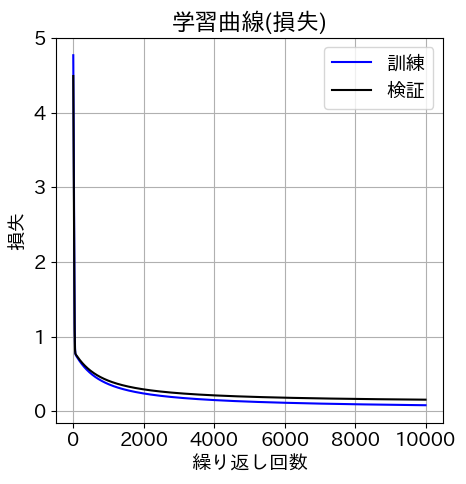

In [27]:
#損失と精度の確認

print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}' )
print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

# 学習曲線の表示 (損失)

plt.plot(history[:,0], history[:,1], 'b', label='訓練')
plt.plot(history[:,0], history[:,3], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('損失')
plt.title('学習曲線(損失)')
plt.legend()
plt.show()

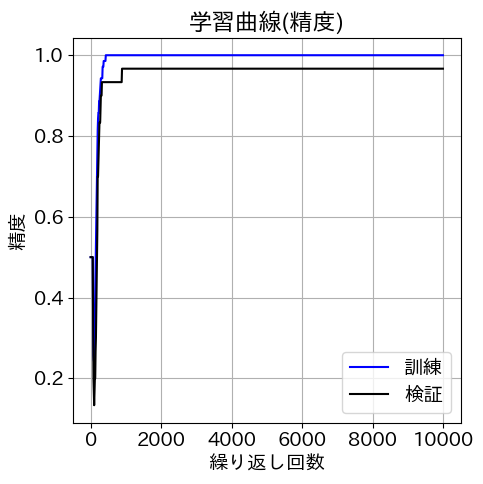

In [28]:
# 学習曲線の表示 (精度)

plt.plot(history[:,0], history[:,2], 'b', label='訓練')
plt.plot(history[:,0], history[:,4], 'k', label='検証')
plt.xlabel('繰り返し回数')
plt.ylabel('精度')
plt.title('学習曲線(精度)')
plt.legend()
plt.show()

In [29]:
#
# 決定境界を可視化
#

bias = net.l1.bias.data.numpy()
weight = net.l1.weight.data.numpy()
print(f'BIAS = {bias}, WEIGHT = {weight}')

# 決定境界描画用 x1の値から x2の値を計算する
def decision(x):
    return(-(bias + weight[0,0] * x)/ weight[0,1])

# 散布図のx1の最小値と最大値
xl = np.array([x_test[:,0].min(), x_test[:,0].max()])
yl = decision(xl)

# 結果確認
print(f'xl = {xl}  yl = {yl}')

BIAS = [0.33861226], WEIGHT = [[ 2.9700334 -5.300017 ]]
xl = [4.4 7. ]  yl = [2.52956916 3.98656204]


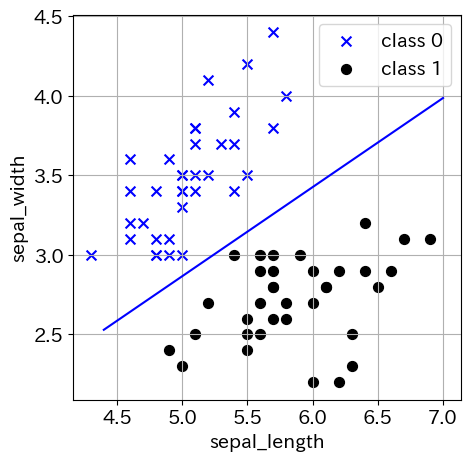

In [30]:
# 散布図表示
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', 
        c='b', s=50, label='class 0')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', 
        c='k', s=50, label='class 1')

# 決定境界直線
plt.plot(xl, yl, c='b')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.legend()
plt.show()